## Import packages

In [1]:
#For this notebook mdtraj version 1.9.5 was used. The package was downloaded using conda from conda-forge.
import mdtraj
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter


# Functions

In [3]:
def get_backbone_atoms(sim, ref_closed):
    '''
    This function selects the backbone atoms of the cyclic peptide 
    '''
    topology = sim.topology
    backbone_atoms = topology.select('(name N or name CA or name O or name C) and not resn POPC')
    topology_ref = ref_closed.topology
    backbone_atoms_ref = topology_ref.select('(name N or name CA or name O or name C) and not resn POPC')
    return backbone_atoms, backbone_atoms_ref, topology

In [4]:
 # RMSD
def get_rmsd(sim, ref_closed,backbone_atoms, backbone_atoms_ref):
    '''
    This function calculates the root-mean-square deviation to the closed structure
    '''
    
    rmsd_closed = mdtraj.rmsd(sim, ref_closed, frame=0, atom_indices=backbone_atoms, ref_atom_indices=backbone_atoms_ref, parallel=True, precentered=False)

    # Table
    data =  {'rmsd_closed':rmsd_closed}
    table_rmsd = pd.DataFrame(data)

    # Filter rmsd
    savgol_length = 15
    savgol_order = 2
    table_rmsd_filtered = savgol_filter(table_rmsd['rmsd_closed'], savgol_length, savgol_order)
    return table_rmsd_filtered

In [5]:
def get_mean_z_value(loaded_sim, frame, index_list):
    '''
    returns the mean z position of a list of atoms
    '''
    return np.mean([loaded_sim.xyz[frame, atom_idx ,2] for atom_idx in index_list])

In [6]:
def get_peptide_position(loaded_sim, backbone_atoms):
    '''
    Returns the mean z-position of the backbone atoms of the cyclic peptides  
    '''
    mean_z_value_traj = [ get_mean_z_value(loaded_sim, frame,backbone_atoms) for frame in range(loaded_sim.n_frames)]
    # use periodic boundaries
    #mean_z_value_traj_pbc = [ mean_z_value_traj[frame] if mean_z_value_traj[frame] < 8 else mean_z_value_traj[frame]-np.max(loaded_sim.xyz[frame, :,2]) for frame in range(loaded_sim.n_frames)]
    return mean_z_value_traj

In [7]:
def get_membrane_position(topology, loaded_sim):
    '''
    Returns the mean z-position of the headgroup and tailgroup region of the POPC membrane 
    '''
    # get position of membrane polar part
    phosphate_atoms = topology.select('name NTM')

    # split in upper and lower leavlet 
    # assumption: no lipid flip during simulation time  
    all_phos_groups_z = [loaded_sim.xyz[1, atom_idx,2] for atom_idx in phosphate_atoms]
    middle_leaflet = 0.5 *(np.max(all_phos_groups_z) - np.min(all_phos_groups_z)) + np.min(all_phos_groups_z)
    index_upper = []
    index_lower = []
    for entry in phosphate_atoms:
        if loaded_sim.xyz[1, entry,2] > middle_leaflet:
            index_upper.append(entry)
        else:
            index_lower.append(entry)


    # calculate position of upper and lower leavlet during simulation         
    upper_leaflet_z_value_traj = [ get_mean_z_value(loaded_sim,frame,index_upper) for frame in range(loaded_sim.n_frames)]
    lower_leaflet_z_value_traj = [ get_mean_z_value(loaded_sim,frame,index_lower) for frame in range(loaded_sim.n_frames)]

    # get position of membrane apolar part
    apolar_atoms = topology.select('name C1B')

    # split in upper and lower leavlet 
    # assumption: no lipid flip during simulation time  
    all_apolar_groups_z = [loaded_sim.xyz[1, atom_idx,2] for atom_idx in apolar_atoms]
    apolar_middle_leaflet = 0.5 *(np.max(all_apolar_groups_z) - np.min(all_apolar_groups_z)) + np.min(all_apolar_groups_z)
    apolar_index_upper = []
    apolar_index_lower = []
    for entry in apolar_atoms:
        if loaded_sim.xyz[1, entry,2] > apolar_middle_leaflet:
            apolar_index_upper.append(entry)
        else:
            apolar_index_lower.append(entry)


    # calculate position of upper and lower leavlet during simulation         
    apolar_upper_leaflet_z_value_traj = [ get_mean_z_value(loaded_sim,frame,apolar_index_upper) for frame in range(loaded_sim.n_frames)]
    apolar_lower_leaflet_z_value_traj = [ get_mean_z_value(loaded_sim,frame,apolar_index_lower) for frame in range(loaded_sim.n_frames)]

    return upper_leaflet_z_value_traj, lower_leaflet_z_value_traj, apolar_upper_leaflet_z_value_traj, apolar_lower_leaflet_z_value_traj


In [9]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)


def angle_between(v1, v2):
    '''
    retruns the angle between two vectors
    '''

    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    
    # calculate sign
    #unit vector that defines sign
    unit_vec_sign = unit_vector(np.array([1,1,1]))
    cross_prod = unit_vector(np.cross(unit_vec_sign,v1_u))
    sinus_vec = np.dot(cross_prod, v2_u)
    
    if sinus_vec >= 0:
        return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))
    else:
        return 2*np.pi - np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [8]:
def get_angle(loaded_sim, name):
    '''
    Calculates the peptide normal vectur using the long and transversal axis if the peptide. 
    Afterwards calculates the angle between this angle and the membrane normal (approximated by z-vector)
    '''
    atoms_long = atoms_angle_dict_long[name]
    atoms_trans = atoms_angle_dict_trans[name]
    # Atoms for longitudinal axis
    ellipsoid_atoms_longitudinal = np.array(atoms_long) #C DPR and C DPR
    # Atoms for transversal axis
    ellipsoid_atoms_transversal = np.array(atoms_trans)   #N MEA and CA MEA
    all_angles_normal = np.zeros(loaded_sim.n_frames)


    for frame in range(loaded_sim.n_frames):
        # get the coordinates of the specified frame 
        ellipsoid_coordinates_longitudinal =  loaded_sim.xyz[frame,ellipsoid_atoms_longitudinal,:]
        ellipsoid_coordinates_transversal =  loaded_sim.xyz[frame,ellipsoid_atoms_transversal,:]

        # get distance vector 
        distance_vector_longitudinal = ellipsoid_coordinates_longitudinal[0] - ellipsoid_coordinates_longitudinal[1]
        distance_vector_transversal = ellipsoid_coordinates_transversal[0] - ellipsoid_coordinates_transversal[1]     

        # other vectors
        peptide_normal_vector = np.cross(distance_vector_longitudinal, distance_vector_transversal)

        # return angles in radians units (normal)
        angle_rad_normal = angle_between(np.array(orientation_dict[name]), peptide_normal_vector)
        all_angles_normal[frame] = angle_rad_normal



    all_angles_normal_cos = np.cos(all_angles_normal)
    #correct for pdb
    #all_angles_normal_cos_corr = [all_angles_normal_cos[frame] if mean_z_value_traj[frame] > middle_leaflet else -all_angles_normal_cos[frame] for frame in range(loaded_sim.n_frames)]

    # Filter
    savgol_length = 15
    savgol_order = 2
    all_angles_normal_cos_corr_filtered = savgol_filter(all_angles_normal_cos, savgol_length, savgol_order)

    return all_angles_normal_cos_corr_filtered

In [10]:
def plot_figure(loaded_sim, mean_z_value_traj, upper_leaflet, lower_leaflet,apolar_upper_leaflet,apolar_lower_leaflet,table_rmsd_filtered, all_angles_normal_cos_corr_filtered,  name):
    '''
    Return manuscript figure of the publication
    '''
    
    color_blue = '#1a4fa3'
    color_orange = '#c75c04'

    fig, host = plt.subplots(figsize=(8,4)) # (width, height) in inches

    par1 = host.twinx()
    par2 = host.twinx()

    host.set_xlim(0, loaded_sim.n_frames)
    host.set_ylim(-0.05,15)
    par1.set_ylim(0, 190)
    par2.set_ylim(0, 0.3)

    host.set_xlabel('time [ns]')
    host.set_ylabel('z-position [nm]')
    par1.set_ylabel(r'orientation [degree]')
    par2.set_ylabel("rmsd to closed [nm]")

    color1 = 'black'
    color2 = color_blue
    color3 = color_orange

    par1.tick_params(axis='y', labelcolor=color2)
    par2.tick_params(axis='y', labelcolor=color3)

    the_frames = range(loaded_sim.n_frames)
    host.scatter(the_frames, mean_z_value_traj,  s=2, c=color1)
    host.plot(the_frames, upper_leaflet,  c='slategrey')
    host.plot(the_frames, lower_leaflet,   c='slategrey')
    host.plot(the_frames, apolar_upper_leaflet,    c='lightgrey')
    host.plot(the_frames, apolar_lower_leaflet,    c='lightgrey')

    angle_corr = np.clip(all_angles_normal_cos_corr_filtered, -1,1)
    angle = np.array(180/np.pi * np.arccos(angle_corr) )
    p2, = par1.plot(the_frames, angle,    color=color2, label="orientation")
    p3, = par2.plot(the_frames, table_rmsd_filtered, color=color3, label="rmsd")


    # right, left, top, bottom
    par2.spines['right'].set_position(('outward', 70))
    par1.spines['top'].set_visible(False)
    par2.spines['top'].set_visible(False)
    host.spines['top'].set_visible(False)


    host.yaxis.label.set_color(color1)
    par1.yaxis.label.set_color(p2.get_color())
    par2.yaxis.label.set_color(p3.get_color())

    # Adjust spacings w.r.t. figsize
    plt.rcParams.update({'font.size': 14})
    par1.set_title(name)
    fig.tight_layout()
    fig.show()

In [11]:
def make_hydrogen_figure(list_hydrogen):
    '''
    Return manuscript figure for hydrogen bonds
    '''
    savgol_length = 15
    savgol_order = 2

    color_red = '#d40f33'
    color_darkred = '#710317'
    color_lightred = '#D37788'
    
    # calculate distance between the hydrogen bond atoms
    distance_hydro_1 = mdtraj.compute_distances(loaded_sim, [[list_hydrogen[0][1],list_hydrogen[0][2]]], periodic=True, opt=True)
    distance_hydro_2 = mdtraj.compute_distances(loaded_sim, [[list_hydrogen[1][1],list_hydrogen[1][2]]], periodic=True, opt=True)
    distance_hydro_3 = mdtraj.compute_distances(loaded_sim, [[list_hydrogen[2][1],list_hydrogen[2][2]]], periodic=True, opt=True)

    #filter
    distance_hydro_1_filtered = savgol_filter(np.concatenate(distance_hydro_1, axis=0), savgol_length, savgol_order)
    distance_hydro_2_filtered = savgol_filter(np.concatenate(distance_hydro_2, axis=0), savgol_length, savgol_order)
    distance_hydro_3_filtered = savgol_filter(np.concatenate(distance_hydro_3, axis=0), savgol_length, savgol_order)
    
    #get membrane representation 
    backbone_atoms, backbone_atoms_ref, topology = get_backbone_atoms(loaded_sim, loaded_reference_closed)
    mean_z_value_traj = get_peptide_position(loaded_sim, backbone_atoms)
    upper_leaflet_z_value_traj, lower_leaflet_z_value_traj, apolar_upper_leaflet_z_value_traj, apolar_lower_leaflet_z_value_traj = get_membrane_position(topology, loaded_sim)

    # mirror to upper leaflet 
    membrane_middle = np.mean(np.array(apolar_lower_leaflet_z_value_traj) + 0.5 * (np.array(apolar_upper_leaflet_z_value_traj) - np.array(apolar_lower_leaflet_z_value_traj)))
    mean_z_value_traj_mirrored = [entry if entry>membrane_middle else 2*membrane_middle-entry for entry in mean_z_value_traj]
    
    fig, ax1 = plt.subplots(figsize=(8,4))

    color = 'black'
    ax1.set_xlabel('time [ns]')
    ax1.set_ylabel('z-position [nm]', color=color)
    number_points = range(len(mean_z_value_traj))
    ax1.scatter(number_points, mean_z_value_traj_mirrored, s=2, c= 'black')
    ax1.plot(number_points, upper_leaflet_z_value_traj,  c='slategrey')
    ax1.plot(number_points, lower_leaflet_z_value_traj,  c='slategrey')
    ax1.plot(number_points, apolar_upper_leaflet_z_value_traj, c='lightgrey')
    ax1.plot(number_points, apolar_lower_leaflet_z_value_traj,  c='lightgrey')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylim(-0.05,15)


    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('distance H-bond-pairs [nm]', color=color_red)  # we already handled the x-label with ax1
    ax2.tick_params(axis='y', labelcolor=color_red)

    ax2.plot(range(len(distance_hydro_1)),distance_hydro_1_filtered, c=color_red, label=(str(topology.atom(list_hydrogen[0][0]))+' '+str(str(topology.atom(list_hydrogen[0][2]))))) 
    ax2.plot(range(len(distance_hydro_1)),distance_hydro_2_filtered, c=color_lightred, label=(str(topology.atom(list_hydrogen[1][0]))+' '+str(str(topology.atom(list_hydrogen[1][2])))))
    ax2.plot(range(len(distance_hydro_1)),distance_hydro_3_filtered, c=color_darkred, label=(str(topology.atom(list_hydrogen[2][0]))+' '+str(str(topology.atom(list_hydrogen[2][2])))))  
    ax2.set_ylim(0,3)
    ax2.legend()

    ax1.spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)

    # Adjust spacings w.r.t. figsize
    plt.rcParams.update({'font.size': 14})
    fig.tight_layout()    
    plt.show()
    

In [22]:
def get_lock_position():
    '''
    Get the position of the phenylalanine lock
    '''

    # get z distance beteen the two Phe CZ atoms
    lock_atoms = list(topology.select('name CZ and resn MEP'))
    
    lock_position1 = loaded_sim.xyz[:, lock_atoms[0] ,2] 
    
    backbone_atoms = list(topology.select('name CA and resn MEP'))
    
    backbone_position1 = loaded_sim.xyz[:, backbone_atoms[0] ,2] 
    
    # Filter rmsd
    savgol_length = 15
    savgol_order = 2
    lock_filtered = savgol_filter(lock_position1 - backbone_position1, savgol_length, savgol_order)
        
    return lock_filtered

In [29]:
def plot_figure_phe(loaded_sim, mean_z_value_traj, upper_leaflet, lower_leaflet,apolar_upper_leaflet,apolar_lower_leaflet,table_rmsd_filtered, phe_position,name):
    '''
    Plots figure for phe lock
    '''
    
    color_blue = '#1a4fa3'
    color_orange = '#c75c04'
    color_red = '#d40f33'

    fig, host = plt.subplots(figsize=(8,4)) # (width, height) in inches

    par1 = host.twinx()
    par2 = host.twinx()

    host.set_xlim(0, loaded_sim.n_frames)
    host.set_xlim(0, 45)
    host.set_ylim(-1.5,14)
    par1.set_ylim(-0.5, 0.5)
    par2.set_ylim(0, 0.3)

    host.set_xlabel('time [ns]')
    host.set_ylabel('z-position [nm]')
    par1.set_ylabel(r'Phe5 position [nm]')
    par2.set_ylabel("rmsd to closed [nm]")

    color1 = 'black'
    color2 = color_red
    color3 = color_orange

    par1.tick_params(axis='y', labelcolor=color2)
    par2.tick_params(axis='y', labelcolor=color3)

    host.scatter(range(loaded_sim.n_frames), mean_z_value_traj,  s=2, c=color1)
    host.plot(range(loaded_sim.n_frames), upper_leaflet,  c='slategrey')
    host.plot(range(loaded_sim.n_frames), lower_leaflet,   c='slategrey')
    host.plot(range(loaded_sim.n_frames), apolar_upper_leaflet,    c='lightgrey')
    host.plot(range(loaded_sim.n_frames), apolar_lower_leaflet,    c='lightgrey')

    p2, = par1.plot(range(loaded_sim.n_frames), phe_position,    color=color2, label="orientation")
    p3, = par2.plot(range(loaded_sim.n_frames), table_rmsd_filtered, color=color3, label="rmsd")


    # right, left, top, bottom
    par2.spines['right'].set_position(('outward', 70))
    par1.spines['top'].set_visible(False)
    par2.spines['top'].set_visible(False)
    host.spines['top'].set_visible(False)


    host.yaxis.label.set_color(color1)
    par1.yaxis.label.set_color(p2.get_color())
    par2.yaxis.label.set_color(p3.get_color())

    # Adjust spacings w.r.t. figsize
    plt.rcParams.update({'font.size': 14})
    par1.set_title(name)
    fig.tight_layout()
    fig.show()
    

In [33]:
atoms_angle_dict_long = {'peptide_6': [26,71],
                        'peptide_8':[23,65],
                        'peptide_3':[29,77],
                        'peptide_1':[26652,26699]} #first C DPR and last C DPR 

atoms_angle_dict_trans = {'peptide_6': [6,55],
                         'peptide_8':[6,50],
                         'peptide_3':[9,59],
                         'peptide_1':[26633,26682]} #first N MEA and last CA MEA
orientation_dict = {'peptide_6': [0,0,1],
                    'peptide_8':[0,0,1],
                   'peptide_3':[0,0,1],
                   'peptide_1':[0,0,1]} #some peptides enter one side of the membrane, other the other side

# Figures

In [44]:
path_to_simulation_data = 'add_path_here'

# FIGURE 3

### Load simulations

In [13]:
simulation =  path_to_simulation_data + 'peptide_1_md_open.pdb'
loaded_reference_closed = mdtraj.load_frame(path_to_simulation_data +'peptide_1_closed.pdb',0)
loaded_sim = mdtraj.load([simulation])
name = 'peptide_1'

### Calculate properties

In [14]:
#get backbone atoms
backbone_atoms, backbone_atoms_ref, topology = get_backbone_atoms(loaded_sim, loaded_reference_closed)
#get rmsd to closed reference
table_rmsd_filtered = get_rmsd(loaded_sim, loaded_reference_closed, backbone_atoms, backbone_atoms_ref)
#get z position of peptide
mean_z_value_traj = get_peptide_position(loaded_sim, backbone_atoms)
    
#get membrane representation 
upper_leaflet_z_value_traj, lower_leaflet_z_value_traj, apolar_upper_leaflet_z_value_traj, apolar_lower_leaflet_z_value_traj = get_membrane_position(topology, loaded_sim)
all_angles_normal_cos_corr_filtered = get_angle(loaded_sim,name)
    
# mirror to upper leaflet 
membrane_middle = np.mean(np.array(apolar_lower_leaflet_z_value_traj) + 0.5 * (np.array(apolar_upper_leaflet_z_value_traj) - np.array(apolar_lower_leaflet_z_value_traj)))
mean_z_value_traj_mirrored = [entry if entry>membrane_middle else 2*membrane_middle-entry for entry in mean_z_value_traj]
all_angles_normal_cos_corr_filtered_mirrored = [all_angles_normal_cos_corr_filtered[angle_index] if mean_z_value_traj[angle_index]>membrane_middle else -all_angles_normal_cos_corr_filtered[angle_index] for angle_index in range(len(all_angles_normal_cos_corr_filtered))]
    

<ipython-input-4-cf3924085d01>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rmsd_closed = mdtraj.rmsd(sim, ref_closed, frame=0, atom_indices=backbone_atoms, ref_atom_indices=backbone_atoms_ref, parallel=True, precentered=False)


### Plot the figure

<ipython-input-10-78b03bc01cd5>:58: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


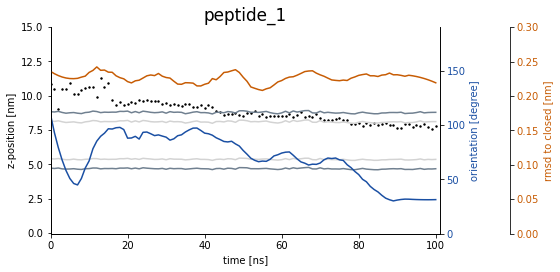

In [15]:
plot_figure(loaded_sim, mean_z_value_traj_mirrored, upper_leaflet_z_value_traj, lower_leaflet_z_value_traj,apolar_upper_leaflet_z_value_traj,apolar_lower_leaflet_z_value_traj,table_rmsd_filtered, all_angles_normal_cos_corr_filtered_mirrored, name)
plt.show()

### Get hydrogen bonds 

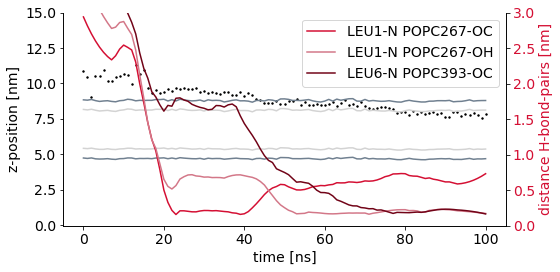

In [16]:
list_hydrogen = mdtraj.baker_hubbard(loaded_sim, freq=0.055, exclude_water=True, periodic=True, sidechain_only=False)
make_hydrogen_figure(list_hydrogen)

# Figure 7

### Load Simulation

In [17]:
simulation =  path_to_simulation_data + 'peptide_6_md_open.pdb'
loaded_reference_closed = mdtraj.load_frame(path_to_simulation_data +'peptide_6_closed.pdb',0)
loaded_sim = mdtraj.load([simulation])
name = 'peptide_6'

### Calculate Properties

In [20]:
#get backbone atoms
backbone_atoms, backbone_atoms_ref, topology = get_backbone_atoms(loaded_sim, loaded_reference_closed)
#get rmsd to closed reference
table_rmsd_filtered = get_rmsd(loaded_sim, loaded_reference_closed, backbone_atoms, backbone_atoms_ref)
#get z position of peptide
mean_z_value_traj = get_peptide_position(loaded_sim, backbone_atoms)
    
#get membrane representation 
upper_leaflet_z_value_traj, lower_leaflet_z_value_traj, apolar_upper_leaflet_z_value_traj, apolar_lower_leaflet_z_value_traj = get_membrane_position(topology, loaded_sim)
all_angles_normal_cos_corr_filtered = get_angle(loaded_sim,name)
    
# mirror to upper leaflet 
membrane_middle = np.mean(np.array(apolar_lower_leaflet_z_value_traj) + 0.5 * (np.array(apolar_upper_leaflet_z_value_traj) - np.array(apolar_lower_leaflet_z_value_traj)))
mean_z_value_traj_mirrored = [entry if entry>membrane_middle else 2*membrane_middle-entry for entry in mean_z_value_traj]
all_angles_normal_cos_corr_filtered_mirrored = [all_angles_normal_cos_corr_filtered[angle_index] if mean_z_value_traj[angle_index]>membrane_middle else -all_angles_normal_cos_corr_filtered[angle_index] for angle_index in range(len(all_angles_normal_cos_corr_filtered))]
    

<ipython-input-4-cf3924085d01>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rmsd_closed = mdtraj.rmsd(sim, ref_closed, frame=0, atom_indices=backbone_atoms, ref_atom_indices=backbone_atoms_ref, parallel=True, precentered=False)


### Plot the figure

<ipython-input-10-78b03bc01cd5>:58: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


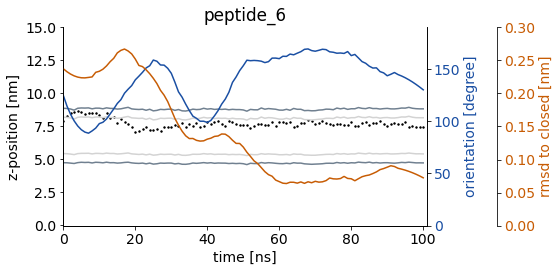

In [21]:
plot_figure(loaded_sim, mean_z_value_traj_mirrored, upper_leaflet_z_value_traj, lower_leaflet_z_value_traj,apolar_upper_leaflet_z_value_traj,apolar_lower_leaflet_z_value_traj,table_rmsd_filtered, all_angles_normal_cos_corr_filtered_mirrored, name)
plt.show()

# Figure 8

### Load the simulation

In [23]:
simulation =  path_to_simulation_data + 'peptide_8_md_open.pdb'
loaded_reference_closed = mdtraj.load_frame(path_to_simulation_data +'peptide_8_closed.pdb',0)
loaded_sim = mdtraj.load([simulation])
name = 'peptide_8'

### Calculate properties 

In [ ]:
#get backbone atoms
backbone_atoms, backbone_atoms_ref, topology = get_backbone_atoms(loaded_sim, loaded_reference_closed)
#get rmsd to closed reference
table_rmsd_filtered = get_rmsd(loaded_sim, loaded_reference_closed, backbone_atoms, backbone_atoms_ref)
#get z position of peptide
mean_z_value_traj = get_peptide_position(loaded_sim, backbone_atoms)
    
#get membrane representation 
upper_leaflet_z_value_traj, lower_leaflet_z_value_traj, apolar_upper_leaflet_z_value_traj, apolar_lower_leaflet_z_value_traj = get_membrane_position(topology, loaded_sim)
#get angle between peptide and membrane 
all_angles_normal_cos_corr_filtered = get_angle(loaded_sim,name)
phe_position = get_lock_position()
    
# mirror to upper leaflet 
membrane_middle = np.mean(np.array(apolar_lower_leaflet_z_value_traj) + 0.5 * (np.array(apolar_upper_leaflet_z_value_traj) - np.array(apolar_lower_leaflet_z_value_traj)))
mean_z_value_traj_mirrored = [entry if entry>membrane_middle else 2*membrane_middle-entry for entry in mean_z_value_traj]
  
  

### Plot the figure

<ipython-input-4-cf3924085d01>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rmsd_closed = mdtraj.rmsd(sim, ref_closed, frame=0, atom_indices=backbone_atoms, ref_atom_indices=backbone_atoms_ref, parallel=True, precentered=False)
<ipython-input-29-18ddbc78f3a0>:58: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


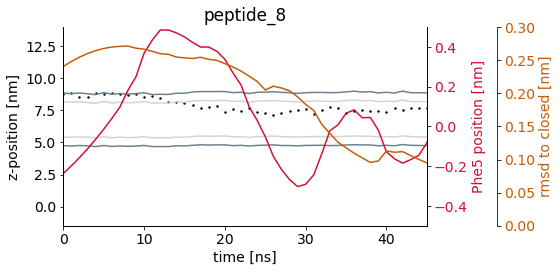

In [30]:
  
plot_figure_phe(loaded_sim, mean_z_value_traj_mirrored, upper_leaflet_z_value_traj, lower_leaflet_z_value_traj,apolar_upper_leaflet_z_value_traj,apolar_lower_leaflet_z_value_traj,table_rmsd_filtered, phe_position,name)
plt.show()
    

# Figure 9

### Load the simulation

In [41]:
simulation =  path_to_simulation_data + 'peptide_3_md_closed.pdb'
loaded_reference_closed = mdtraj.load_frame(path_to_simulation_data +'peptide_3_closed.pdb',0)
loaded_sim = mdtraj.load([simulation])
name = 'peptide_3'

### Calculate properties

In [42]:
#get backbone atoms
backbone_atoms, backbone_atoms_ref, topology = get_backbone_atoms(loaded_sim, loaded_reference_closed)
#get rmsd to closed reference
table_rmsd_filtered = get_rmsd(loaded_sim, loaded_reference_closed, backbone_atoms, backbone_atoms_ref)
#get z position of peptide
mean_z_value_traj = get_peptide_position(loaded_sim, backbone_atoms)
    
#get membrane representation 
upper_leaflet_z_value_traj, lower_leaflet_z_value_traj, apolar_upper_leaflet_z_value_traj, apolar_lower_leaflet_z_value_traj = get_membrane_position(topology, loaded_sim)
all_angles_normal_cos_corr_filtered = get_angle(loaded_sim,name)
    
# mirror to upper leaflet 

dipole_traj_debeye_mirrored = []
membrane_middle = np.mean(np.array(apolar_lower_leaflet_z_value_traj) + 0.5 * (np.array(apolar_upper_leaflet_z_value_traj) - np.array(apolar_lower_leaflet_z_value_traj)))
mean_z_value_traj_mirrored = [2*membrane_middle-entry for entry in mean_z_value_traj]
    

<ipython-input-4-cf3924085d01>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rmsd_closed = mdtraj.rmsd(sim, ref_closed, frame=0, atom_indices=backbone_atoms, ref_atom_indices=backbone_atoms_ref, parallel=True, precentered=False)


### Plot the figure

<ipython-input-10-78b03bc01cd5>:58: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


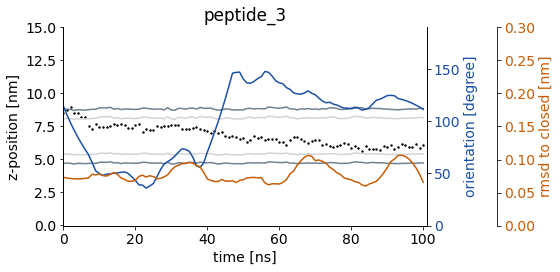

In [43]:
plot_figure(loaded_sim, mean_z_value_traj_mirrored, upper_leaflet_z_value_traj, lower_leaflet_z_value_traj,apolar_upper_leaflet_z_value_traj,apolar_lower_leaflet_z_value_traj,table_rmsd_filtered, all_angles_normal_cos_corr_filtered, name)
plt.show()